# Lecture outline

1. Experimental framework implementation
1. Performance evaluation
1. Assignments

# 1. Experimental framework implementation

## Best practice to implement $n$ heuristics and $m$ objective functions?

* There are some common characteristics for all objects in our framework
  * Heuristics - store best found solution, manage stop criterion, etc.
  * Objective functions - store $f^*$, lower/upper bounds, etc.
* Every specific heuristic or obj. function implements its own search space exploration or evaluation, neighbourhood generation, etc.
* Thus, object-oriented design should help us to separate this concerns as much as possible and also to keep us sane


<img src="img/oop_design.png">


## Example: generalized Shoot&Go and two objective functions (AirShip and `sum(x)`)


### Generalized Shoot&Go: $\mathrm{SG}_{hmax}$

* Shoot & Go heuristic (also known as *Iterated Local Search*, *Random-restart hill climbing*, etc)
    * $hmax \in \{ 0, 1, \ldots, \infty \}$ parameter - maximum number of local searches / hill climbs
    * note that $\mathrm{SG}_{0}$ is pure Random Shooting (Random Search)
    
* implemented as ``class ShootAndGo(Heuristic)`` in ``src/heur.py``    
    
### Objective functions

#### AirShip

* Same as on previous lecture, but wee need to **minimize** obj. function values
* implemented as ``class AirShip(ObjFun)`` in ``src/objfun.py``

#### `sum(x)`

* Just as demonstration of vectorized lower/upper bounds
* implemented as ``class Sum(ObjFun)`` in ``src/objfun.py``

**Review the code, please!**

# 2. Performance evaluation

## What is the recommended approach to store and analyze results of your experiments?

1. Append all relevant statistics from a single run into table (e.g. CSV file in memory or on disk), including all task and heuristic parameters 
2. Load the table into analytical tool of your choice (data frames, Excel or Google Docs spreadsheets, etc.)
3. Pivot by relevant parameters, visualize in tables or charts

## Demonstration

Neccessary notebook setup first:

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd,'../src'))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

In [2]:
# Import extrenal librarires
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

# Import our code
from heur import ShootAndGo

### General experiment setup

Runs selected objective function (`of`) using selected heuristic multiple times, stores and returns data (results) in a data frame.

In [3]:
def experiment(of, num_runs, hmax):
    results = []
    for i in tqdm_notebook(range(num_runs), 'Testing hmax = {}'.format(hmax)):
        result = ShootAndGo(of, maxeval=100, hmax=hmax).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}'.format(hmax) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    return pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])

### Air Ship experiments

In [4]:
from objfun import AirShip
of = AirShip()

In [5]:
table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(of, 10000, hmax)
    table = pd.concat([table, res], axis=0)

**Note**: This is what you should see while experiments are in progress:

<img src="img/tqdm_progress.png">

In [6]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 9999
Data columns (total 6 columns):
heur      80000 non-null object
run       80000 non-null int64
hmax      80000 non-null float64
best_x    80000 non-null int64
best_y    80000 non-null float64
neval     80000 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 4.3+ MB


In [7]:
table.head()

,heur,run,hmax,best_x,best_y,neval
0,SG_0,0,0.0,49,-98.0,inf
1,SG_0,1,0.0,39,-78.0,inf
2,SG_0,2,0.0,43,-86.0,inf
3,SG_0,3,0.0,52,-96.0,inf
4,SG_0,4,0.0,51,-98.0,inf


In [8]:
# import visualization libraries
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Quality of solutions based on `hmax`?

In **tabular** form:

In [9]:
table.groupby(['hmax'])['best_y'].median()

hmax
0.000000    -94.000000
1.000000    -86.000000
2.000000    -86.000000
5.000000    -72.000000
10.000000   -62.000000
20.000000   -49.494949
50.000000   -29.797980
inf         -25.000000
Name: best_y, dtype: float64

In [10]:
table.groupby(['hmax'])['best_y'].mean()

hmax
0.000000    -91.976214
1.000000    -80.592142
2.000000    -80.394173
5.000000    -68.753631
10.000000   -62.741859
20.000000   -55.220627
50.000000   -45.813633
inf         -38.820442
Name: best_y, dtype: float64

Feel free to compute other statistics instead of median and mean.

Directly as **Box-Whiskers plot**:

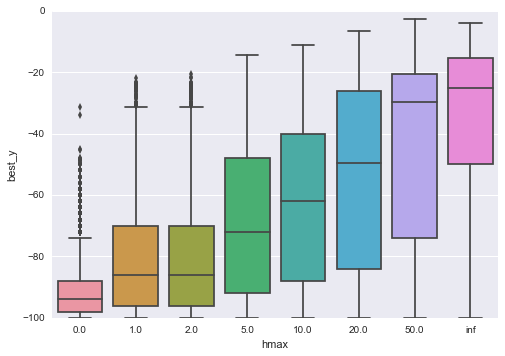

In [11]:
ax = sns.boxplot(x="hmax", y="best_y", data=table)

#### Number of evaluations (when successful), based on `hmax`?

Let's add another column, `success`:

In [12]:
table['success'] = table['neval'] < np.inf

In [13]:
table[table['success'] == True].head()

,heur,run,hmax,best_x,best_y,neval,success
7,SG_0,7,0.0,50,-100.0,23.0,True
12,SG_0,12,0.0,50,-100.0,11.0,True
19,SG_0,19,0.0,50,-100.0,83.0,True
35,SG_0,35,0.0,50,-100.0,86.0,True
41,SG_0,41,0.0,50,-100.0,54.0,True


In [14]:
table[table['success'] == False].head()

,heur,run,hmax,best_x,best_y,neval,success
0,SG_0,0,0.0,49,-98.0,inf,False
1,SG_0,1,0.0,39,-78.0,inf,False
2,SG_0,2,0.0,43,-86.0,inf,False
3,SG_0,3,0.0,52,-96.0,inf,False
4,SG_0,4,0.0,51,-98.0,inf,False


Table:

In [15]:
table[table['success'] == True].groupby(['hmax'])['neval'].mean()

hmax
0.000000     49.846774
1.000000     48.863675
2.000000     49.891892
5.000000     49.691076
10.000000    49.655738
20.000000    51.313320
50.000000    51.080324
inf          53.600941
Name: neval, dtype: float64

In [16]:
table[table['success'] == True].groupby(['hmax'])['neval'].median()

hmax
0.000000     49.0
1.000000     48.0
2.000000     49.0
5.000000     49.0
10.000000    50.0
20.000000    51.0
50.000000    50.0
inf          55.0
Name: neval, dtype: float64

Chart:

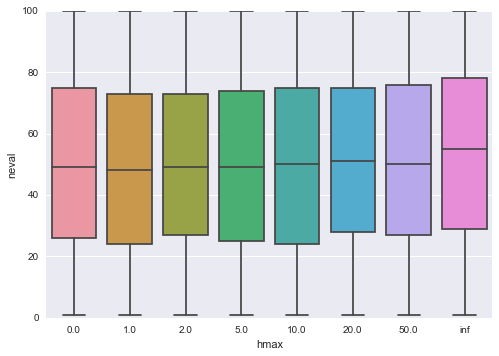

In [17]:
ax = sns.boxplot(x="hmax", y="neval", data=table[table['success'] == True])

#### Reliability

In [18]:
rel_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: len([n for n in x if n < np.inf])/len(x)
)

In [19]:
rel_by_hmax

,neval
hmax,
0.000000,0.1116
1.000000,0.1181
2.000000,0.1147
5.000000,0.1311
10.000000,0.1281
20.000000,0.1449
50.000000,0.1606
inf,0.1912


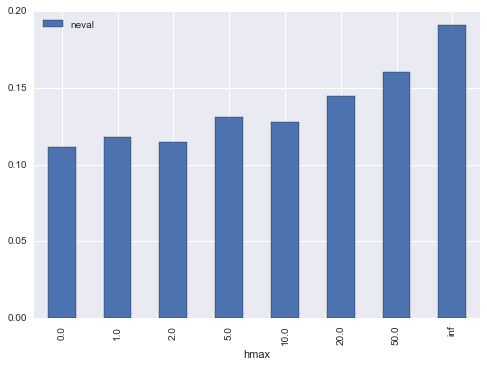

In [20]:
ax = rel_by_hmax.plot(kind='bar')

#### Speed, normalized by reliability?

* Reliability: $REL = m/q$ where $m$ is number of successful runs and $q$ is total number of runs, $REL \in [0, 1]$
* Mean Number of objective function Evaluations: $MNE = \frac{1}{m} \sum_{i=1}^m neval_i$
* Feoktistov criterion: $FEO = MNE/REL$

In [21]:
feo_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: np.mean([n for n in x if n < np.inf])/(len([n for n in x if n < np.inf])/len(x))
    #                 ^^^   mean number of evaluations ^^^ / ^^^             reliability         ^^^^
)

In [22]:
feo_by_hmax

,neval
hmax,
0.000000,446.655683
1.000000,413.748305
2.000000,434.977261
5.000000,379.031850
10.000000,387.632613
20.000000,354.129189
50.000000,318.059301
inf,280.339652


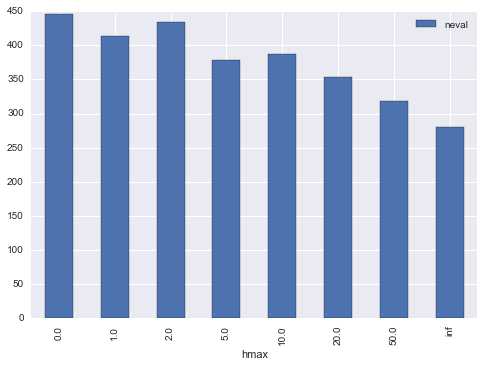

In [23]:
ax = feo_by_hmax.plot(kind='bar')

### `sum(x)` experiments

Let's review this function a little bit:

In [24]:
from objfun import Sum
of = Sum([0, 0, 0, 0], [10, 10, 10, 10])

In [25]:
x = of.generate_point()
print(x)
print(of.evaluate(x))

[2, 5, 5, 3]
15


In [26]:
print(of.get_neighborhood(x, 1))

[[1, 5, 5, 3], [3, 5, 5, 3], [2, 4, 5, 3], [2, 6, 5, 3], [2, 5, 4, 3], [2, 5, 6, 3], [2, 5, 5, 2], [2, 5, 5, 4]]


In [27]:
print(of.get_neighborhood(x, 2))

AssertionError: Sum(x) supports neighbourhood with distance = 1 only

^^ This behaviour is intended. See code for details.

In [28]:
of.get_neighborhood([0, 0, 0, 0], 1)

[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

In [29]:
of.get_neighborhood([10, 10, 10, 10], 1)

[[9, 10, 10, 10], [10, 9, 10, 10], [10, 10, 9, 10], [10, 10, 10, 9]]

And now, perform traditional experiments:

In [30]:
table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]:
    res = experiment(of, 10000, hmax)
    table = pd.concat([table, res], axis=0)

#### Quality of solutions based on hmax?

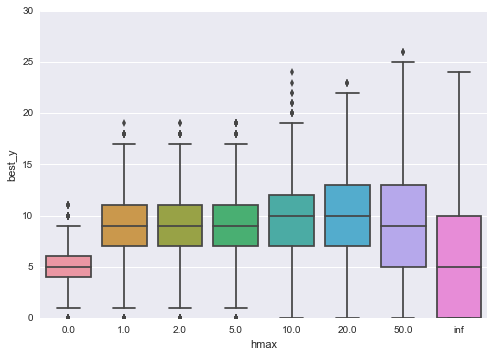

In [31]:
ax = sns.boxplot(x="hmax", y="best_y", data=table)

#### Number of evaluations (when successful), based on hmax?

In [32]:
table['success'] = table['neval'] < np.inf

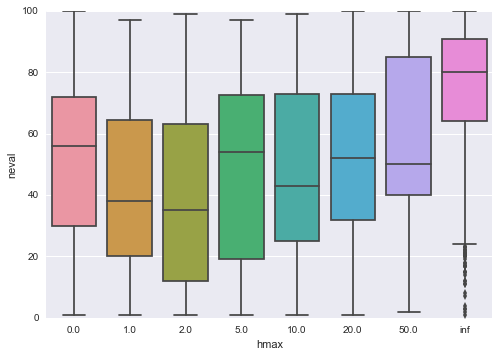

In [33]:
ax = sns.boxplot(x="hmax", y="neval", data=table[table['success'] == True])

#### Reliability?

In [34]:
rel_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: len([n for n in x if n < np.inf])/len(x)
)

In [35]:
rel_by_hmax

,neval
hmax,
0.000000,0.0077
1.000000,0.0039
2.000000,0.0028
5.000000,0.0043
10.000000,0.0077
20.000000,0.0216
50.000000,0.0693
inf,0.2845


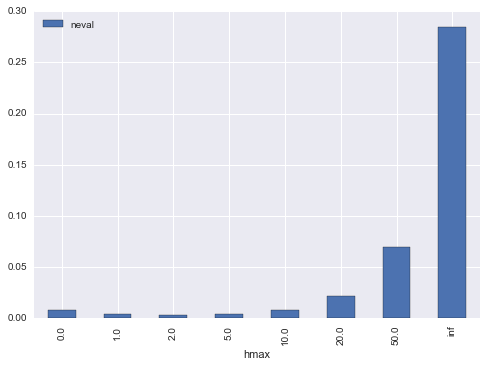

In [36]:
ax = rel_by_hmax.plot(kind='bar')

#### Feoktistov criterion?

In [37]:
feo_by_hmax = table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: np.mean([n for n in x if n < np.inf])/(len([n for n in x if n < np.inf])/len(x))
)

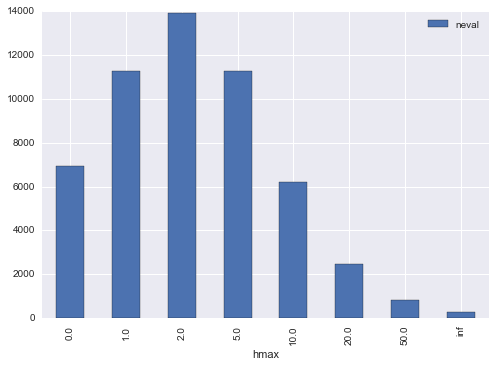

In [38]:
ax = feo_by_hmax.plot(kind='bar')

# Assignments

1. Implement examples in this notebook on your own
1. Experiment with **neighbourhood diameter** `d` in `AirShip.get_neighborhood(x, d)`
1. Add new heuristics into existing framework and analyze their performance:
   1. **Random Descent**, similar to Shoot & Go, but does not follow steepest descent, chooses direction of the descent randomly instead
   1. **Taboo Search**